In [1]:
import os

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
def get_files(folder):
    filenames = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith(".png") and "imgs" in root:
                filenames.append(os.path.join(root, file))
    return filenames

def normalize(image):
    image = tf.cast(image, tf.float32) / 255.0
    return image


def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, IMSIZE)
    return image


def load_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMSIZE)
    return mask


def load_image_pair(image_path):
    image = load_image(image_path[0])
    mask = load_mask(image_path[1])
    image = normalize(image)
    mask = normalize(mask)
    return image, mask

def create_dataset(paths, batch_size=32, buffer_size=100):
    dataset = tf.data.Dataset.from_tensor_slices(paths)
    dataset = dataset.map(load_image_pair, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    batches = (
        dataset
        .cache()
        .shuffle(buffer_size)
        .batch(batch_size)
        .prefetch(tf.data.experimental.AUTOTUNE)
    )
    return batches

In [3]:
# Create the dataset
BUFFER_SIZE = 100
BATCH_SIZE = 32
IMSIZE = (256, 256)

files = get_files("data/")
train_paths = [(path, path.replace("imgs", "targets")) for path in files if "train" in path]
test_paths = [(path, path.replace("imgs", "targets")) for path in files if "test" in path]
val_paths = [(path, path.replace("imgs", "targets")) for path in files if "valid" in path]

print("Number of training samples: ", len(train_paths),
      "\nNumber of validation samples: ", len(val_paths),
      "\nNumber of test samples: ", len(test_paths))

train_batches = create_dataset(train_paths, batch_size=BATCH_SIZE, buffer_size=BUFFER_SIZE)
test_batches = create_dataset(test_paths, batch_size=BATCH_SIZE, buffer_size=BUFFER_SIZE)
val_batches = create_dataset(val_paths, batch_size=BATCH_SIZE, buffer_size=BUFFER_SIZE)

Number of training samples:  320 
Number of validation samples:  91 
Number of test samples:  47


In [4]:
# set up the model architecture (simple baseline model)
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[*IMSIZE, 1]),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(np.prod(IMSIZE), activation='sigmoid'),
    tf.keras.layers.Reshape((*IMSIZE, 1))
])

# compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

model.summary()

EPOCHS = 40
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=val_batches,
                    verbose=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 1024)              67109888  
                                                                 
 dense_1 (Dense)             (None, 65536)             67174400  
                                                                 
 reshape (Reshape)           (None, 256, 256, 1)       0         
                                                                 
Total params: 134,284,288
Trainable params: 134,284,288
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
10/10 - 3s - loss: 0.2914 - accuracy: 0.8586 - val_loss: 0.1774 - val_accuracy: 0.9207 - 3s/epoch - 288ms/step
Epoch 2/40
10/10 - 0s - loss: 0.1689 - accuracy: 0.9

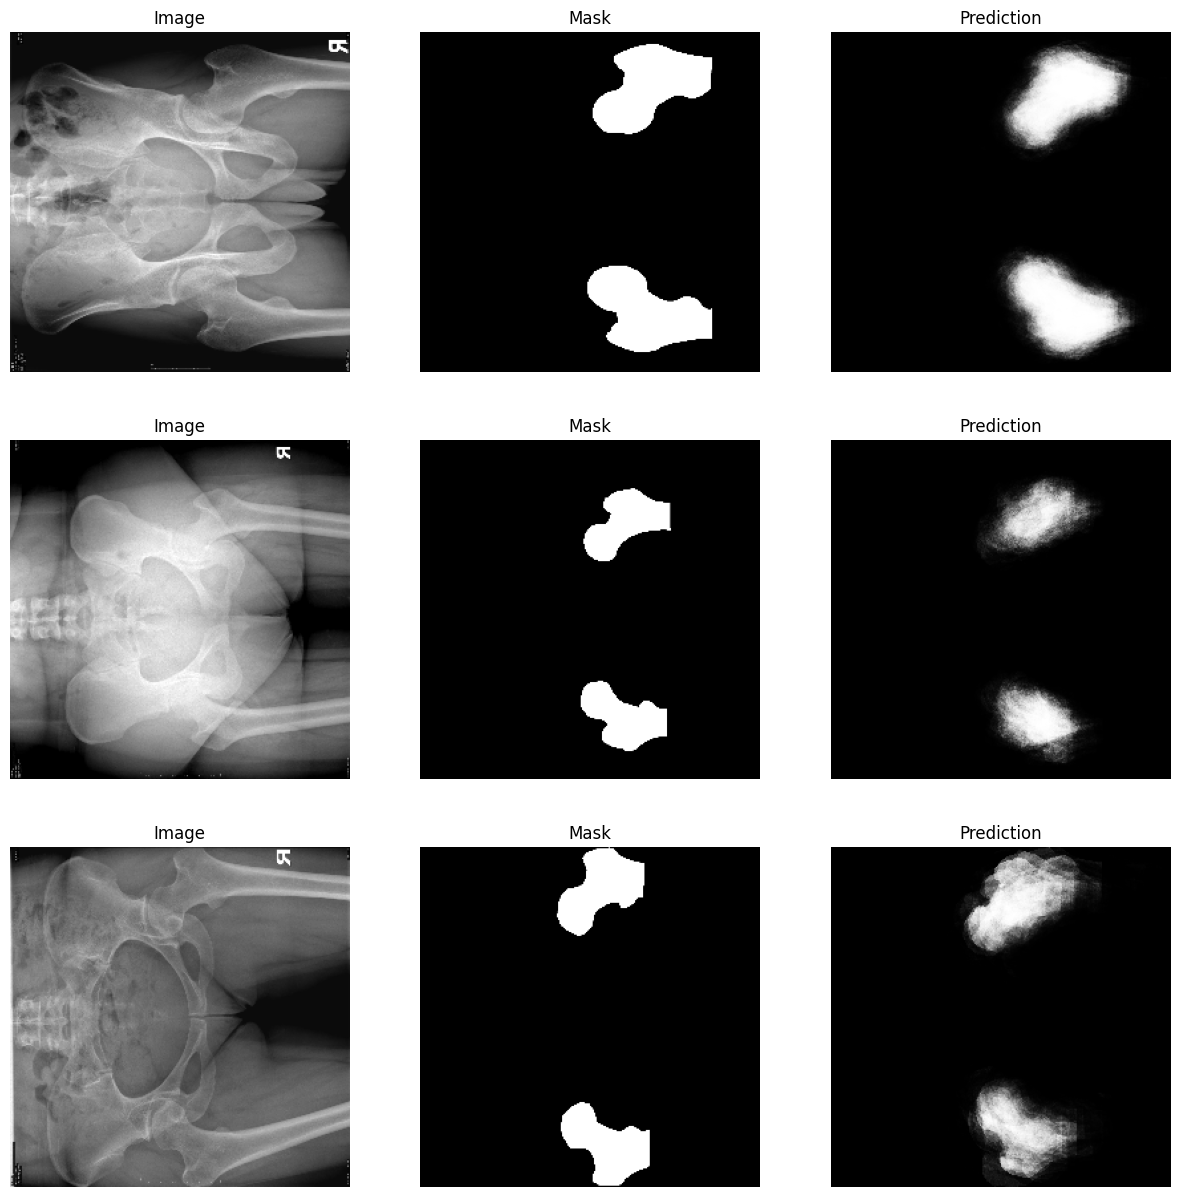

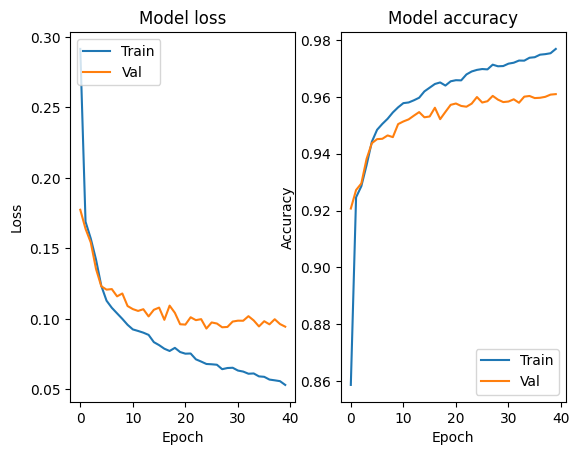

In [6]:
# evaluate the model
for images, masks in test_batches.take(1):
    predictions = model.predict(images)
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    for ii, (img, msk, prediction) in enumerate(zip(images, masks, predictions)):
        axs[ii, 0].imshow(img, cmap='gray')
        axs[ii, 1].imshow(msk, cmap='gray')
        axs[ii, 2].imshow(prediction, cmap='gray')
        axs[ii, 0].axis("off")
        axs[ii, 1].axis("off")
        axs[ii, 2].axis("off")
        axs[ii, 0].set_title("Image")
        axs[ii, 1].set_title("Mask")
        axs[ii, 2].set_title("Prediction")
        if ii == 2:
            break

fig, axs = plt.subplots(1, 2)
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[0].set_title('Model loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Val'], loc='upper left')
axs[1].set_title('Model accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Val'], loc='lower right')
plt.show()